<a href="https://colab.research.google.com/github/erinijapranckeviciene/MF54609_18981_1_20241/blob/main/FC_book_Ch_12_Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative deep learning

### 12.3 Neural style transfer (F.Collet book page 383)

..."The key notion behind implementing style transfer is the same idea that’s central
to all deep learning algorithms: you define a loss function to specify what you want to
achieve, and you minimize this loss. We know what we want to achieve: conserving the
content of the original image while adopting the style of the reference image. If we
were able to mathematically define content and style, then an appropriate loss function
to minimize would be the following:

```
loss = (distance(style(reference_image) - style(combination_image)) +
distance(content(original_image) - content(combination_image)))
```

Here, distance is a norm function such as the L2 norm, content is a function that
takes an image and computes a representation of its content, and style is a function
that takes an image and computes a representation of its style.

Minimizing this loss
causes style(combination_image) to be close to style(reference_image), and
content(combination_image) is close to content(original_image), thus achieving
style transfer as we defined it."...

(p. 385) ..."In short, you can use a pretrained convnet to define a loss that will do the following:

  - Preserve content by maintaining similar high-level layer activations between the
original image and the generated image. The convnet should “see” both the
original image and the generated image as containing the same things.
  - Preserve style by maintaining similar correlations within activations for both low-
level layers and high-level layers. Feature correlations capture textures: the generated image and the style-reference image should share the same textures at
different spatial scales.


Now let’s look at a Keras implementation of the original 2015 neural style transfer
algorithm. As you’ll see, it shares many similarities with the DeepDream implementa-
tion we developed in the previous section."...

### 12.3.3 Neural style transfer in Keras

Here’s the general process:
  - Set up a network that computes VGG19 layer activations for the style-reference
image, the base image, and the generated image at the same time.
  - Use the layer activations computed over these three images to define the loss
function described earlier, which we’ll minimize in order to achieve style
transfer.
  - Set up a gradient-descent process to minimize this loss function.

### Listing 12.16 Getting the style and content images

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
  "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
  "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

575046/575046 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step
943128/943128 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


#### Base image

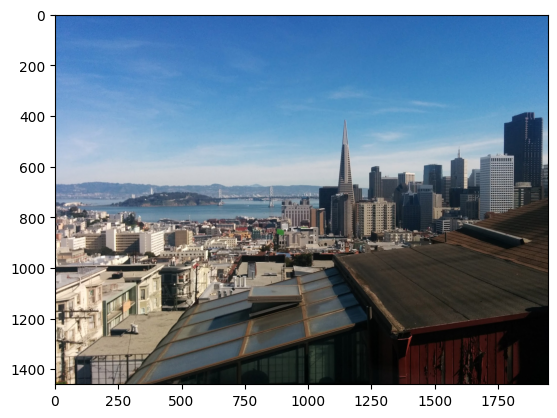

In [2]:
import matplotlib.pyplot as plt

plt.imshow(keras.utils.load_img(base_image_path))
plt.show()

#### Style reference

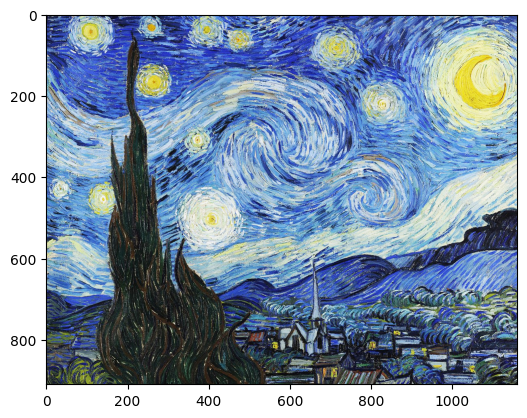

In [3]:
plt.imshow(keras.utils.load_img(style_reference_image_path))
plt.show()

### Listing 12.17 Auxiliary functions

In [4]:
import numpy as np

def preprocess_image(image_path):
  img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.vgg19.preprocess_input(img)
  return img

def deprocess_image(img):
  img = img.reshape((img_height, img_width, 3))
  img[:, :, 0] += 103.939
  img[:, :, 1] += 116.779
  img[:, :, 2] += 123.68
  img = img[:, :, ::-1]
  img = np.clip(img, 0, 255).astype("uint8")
  return img



### Listing 12.18 Using a pretrained VGG19 model to create a feature extractor

In [5]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### Listing 12.19 Content loss

In [6]:
def content_loss(base_img, combination_img):
  return tf.reduce_sum(tf.square(combination_img - base_img))

### Listing 12.20 Style loss

In [8]:
def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

def style_loss(style_img, combination_img):
  S = gram_matrix(style_img)
  C = gram_matrix(combination_img)
  channels = 3
  size = img_height * img_width
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

### Listing 12.21 Total variation loss

In [9]:
def total_variation_loss(x):
  a = tf.square( x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
  b = tf.square( x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, 1.25))

### Listing 12.22 Defining the final loss that you’ll minimize

In [10]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
  input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
  features = feature_extractor(input_tensor)
  loss = tf.zeros(shape=())
  layer_features = features[content_layer_name]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  loss = loss + content_weight * content_loss(base_image_features, combination_features)
  for layer_name in style_layer_names:
    layer_features = features[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss_value = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layer_names)) * style_loss_value
  loss += total_variation_weight * total_variation_loss(combination_image)
  return loss


### Listing 12.23 Setting up the gradient-descent process

In [11]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_image, base_image, style_reference_image)
  grads = tape.gradient(loss, combination_image)
  return loss, grads

optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
  loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
  optimizer.apply_gradients([(grads, combination_image)])
  if i % 100 == 0:
    print("Iteration %d: loss=%.2f" % (i, loss))
    img = deprocess_image(combination_image.numpy())
    fname = "generated_at_iteration_%d.png" % i
    keras.utils.save_img(fname, img)


Iteration 100: loss=8138.01
Iteration 200: loss=6652.76
Iteration 300: loss=6062.72
Iteration 400: loss=5741.88
Iteration 500: loss=5535.31
Iteration 600: loss=5389.79
Iteration 700: loss=5280.39
Iteration 800: loss=5195.07
Iteration 900: loss=5126.21
Iteration 1000: loss=5069.29
Iteration 1100: loss=5021.41
Iteration 1200: loss=4980.70
Iteration 1300: loss=4945.36
Iteration 1400: loss=4914.39
Iteration 1500: loss=4887.04
Iteration 1600: loss=4862.87
Iteration 1700: loss=4841.36
Iteration 1800: loss=4822.03
Iteration 1900: loss=4804.59
Iteration 2000: loss=4788.75
Iteration 2100: loss=4774.38
Iteration 2200: loss=4761.22
Iteration 2300: loss=4749.13
Iteration 2400: loss=4738.03
Iteration 2500: loss=4727.77
Iteration 2600: loss=4718.31
Iteration 2700: loss=4709.54
Iteration 2800: loss=4701.38
Iteration 2900: loss=4693.79
Iteration 3000: loss=4686.72
Iteration 3100: loss=4680.12
Iteration 3200: loss=4673.95
Iteration 3300: loss=4668.16
Iteration 3400: loss=4662.73
Iteration 3500: loss=46

#### It takes really long time to generate images. This is what we get.

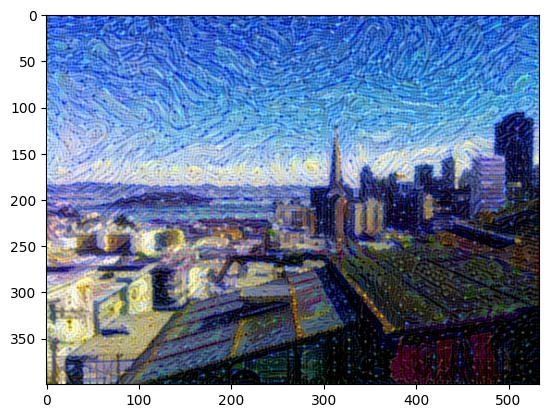

In [13]:
plt.imshow(keras.utils.load_img("generated_at_iteration_4000.png"))
plt.show()

In [14]:
!mkdir img

In [15]:
!mv generated* img

In [17]:
#!zip -r img.zip img